In [2]:
import numpy as np
import pandas as pd
from astropy.io import ascii
from scipy import stats
from scipy.optimize import minimize,curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from multiprocessing import Pool
# import warnings
# warnings.filterwarnings(action='ignore')
np.random.seed(9620)
sns.set(style='ticks', context='talk')
plt.style.use("../paper.mplstyle")

# from snpy import get_sn
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u

from warnings import filterwarnings
filterwarnings(action='ignore')

# Base data prep

## MaNGA DRPALL catalog
https://www.sdss.org/dr15/manga/manga-data/catalogs/

In [30]:
from astropy.table import Table
drpall = Table.read('manga-drpall-v2_4_3.fits')
print(len(drpall))

11465


In [6]:
drpall[:3]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7]
int64,bytes21,bytes11,bytes11,bytes6,bytes6,bytes6,bytes7,bytes4,bytes14,bytes12,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes35,int64,bytes11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes19,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8935,12701,8935-12701,1-404249,v2_4_3,v2_4_3,v1_6_2,v5_5_32,v2_5,APOGEE-2&MaNGA,MaNGA dither,194.523423939,29.0173526307,85.4656882782,87.6076553974,194.52342,29.017353,0.00884234,9,8100.82,0,26.412,54.6103,ma087,22,4,9555,195.773,28.079836,1.00379,1.0207,1.05363,1.4388,1.6464,1.77775,0.778568,0.894813,0.908259,57809,57809,57813,2.77918,2.69495,2.66897,2.65623,4288,0,0,1,plateTargets-1.par,6460,J125805.61+290102.5,127,127,0,0.0256766,0.0154936,0.0240863,0.0334392,0.0359381,0.0146675,0.0285023,0.67973,-999.0,-999.0,-999.0,-999.0,-999.0,0.969534,0.712336,0.736879,17,4646,2,v1_0_1,427604,-999,0.0256766,0.0255916,-11.0607 .. -18.7128,-10.5316 .. -18.6375,0.432649 .. 455.756,2118210000.0,1815790000.0,0.324917,120.306,0.0732985 .. 0.013077,8.44811,6.03505,-0.0303539 .. 448.859,7.34277 .. 0.00210648,0.208874 .. 476.131,11.6981 .. 0.00401799,0.236697,1.81745,120.453,9.97898,0.341969 .. 510.043,43.3074 .. 0.023001
9118,12701,9118-12701,7-18517934,v2_4_3,v2_4_3,v1_6_2,v5_5_32,v2_5,APOGEE-2&MaNGA,APOGEE lead,298.03371,27.752152,64.2679758563,0.353438351451,298.03371,27.752152,3.31319,5,4500.35,0,0.0,0.0,ma126,22,6,9738,298.80339,28.1979,1.00475,1.0183,1.05045,1.38691,1.4556,1.57828,0.668318,0.682418,0.685484,57679,57679,57679,-999.0,-999.0,-999.0,-999.0,0,1280,0,7,plateTargets-7.par,-9999,-9999,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,-9999,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0 .. -9999.0,-9999.0 .. -9999.0,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0 .. -9999.0,-9999.0 .. -9999.0,-9999.0 .. -9999.0,-9999.0 .. -9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0 .. -9999.0,-9999.0 .. -9999.0
7977,12701,7977-12701,1-114955,v2_4_3,v2_4_3,v1_6_2,v5_5_32,v2_5,APOGEE-2&MaNGA,MaNGA dither,332.602089837,11.7130772993,72.4212455762,-34.9232891856,332.60209,11.713077,0.0945308,12,10801.0,64,32.4432,64.4726,ma079,22,3,8388,331.97449,12.6171,1.07178,1.09856,1.20416,1.44968,1.61633,1.81268,0.934917,0.970877,0.990708,56898,56899,56899,2.56749,2.59933,2.59609,2.58139,2080,0,0,1,plateTargets-1.par,5746,J221024.49+114247.0,127,127,0,0.0922799,0.0337

0.0473019


## Pipe3D VAC
DR15: https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=manga-pipe3d-value-added-catalog-spatially-resolved-and-integrated-properties-of-galaxies-for-dr15 <br>
DR14: https://www.sdss.org/dr14/manga/manga-data/manga-pipe3d-value-added-catalog/

In [31]:
from astropy.table import Table
table_p3d = Table.read('manga.Pipe3D-v2_4_3.fits')
print(len(table_p3d))

4656


In [66]:
table_p3d

mangaid,objra,objdec,redshift,re_arc,pa,ellip,dl,re_kpc,log_mass,e_log_mass,log_sfr_ha,e_log_sfr_ha,log_sfr_ssp,e_log_sfr_ssp,log_mass_gas,e_log_mass_gas,age_lw_re_fit,e_age_lw_re_fit,alpha_age_lw_re_fit,e_alpha_age_lw_re_fit,age_mw_re_fit,e_age_mw_re_fit,alpha_age_mw_re_fit,e_alpha_age_mw_re_fit,zh_lw_re_fit,e_zh_lw_re_fit,alpha_zh_lw_re_fit,e_alpha_zh_lw_re_fit,zh_mw_re_fit,e_zh_mw_re_fit,alpha_zh_mw_re_fit,e_alpha_zh_mw_re_fit,av_ssp_re,e_av_ssp_re,av_gas_re,e_av_gas_re,oh_re_fit_o3n2,e_oh_re_fit_o3n2,alpha_oh_re_fit_o3n2,e_alpha_oh_re_fit_o3n2,oh_re_fit_n2,e_oh_re_fit_n2,alpha_oh_re_fit_n2,e_alpha_oh_re_fit_n2,oh_re_fit_ons,e_oh_re_fit_ons,alpha_oh_re_fit_ons,e_alpha_oh_re_fit_ons,oh_re_fit_pyqz,e_oh_re_fit_pyqz,alpha_oh_re_fit_pyqz,e_alpha_oh_re_fit_pyqz,oh_re_fit_t2,e_oh_re_fit_t2,alpha_oh_re_fit_t2,e_alpha_oh_re_fit_t2,oh_re_fit_m08,e_oh_re_fit_m08,alpha_oh_re_fit_m08,e_alpha_oh_re_fit_m08,oh_re_fit_t04,e_oh_re_fit_t04,alpha_oh_re_fit_t04,e_alpha_oh_re_fit_t04,no_re_fit_epm09,e_no_re_fit_epm09,alpha_no_re_fit_epm09,e_alpha_no_re_fit_epm09,no_re_fit_n2s2,e_no_re_fit_n2s2,alpha_no_re_fit_n2s2,e_alpha_no_re_fit_n2s2,log_nii_ha_cen,e_log_nii_ha_cen,log_oiii_hb_cen,e_log_oiii_hb_cen,log_sii_ha_cen,e_log_sii_ha_cen,log_oii_hb_cen,e_log_oii_hb_cen,ew_ha_cen,e_ew_ha_cen,ion_class_cen,sigma_cen,e_sigma_cen,sigma_cen_ha,e_sigma_cen_ha,vel_sigma_re,e_vel_sigma_re,lambda_re,e_lambda_re,plateifu,plate,ifudsgn
,degree,degree,,arcsec,degrees,,,kpc,log(msun),log(msun),log(msun/yr),log(msun/yr),log(msun/yr),log(msun/yr),log(msun),log(msun),log(yr),log(yr),,,log(yr),log(yr),,,log(yr),log(yr),,,log(yr),log(yr),,,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,km / s,km / s,km / s,,,,,,,
bytes128,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes128,int32,int32
manga-10001-12701,133.3711,57.598427,0.039515216,5.16633,158.2584,0.9089005,169.82077,3.9365368,9.993362,0.09378911,-0.11360164,0.06162829,0.321006,0.0030126863,9.30276,0.23200081,8.627869,0.030078521,-0.04584963,0.03300304,9.638159,0.07926918,0.040035605,0.08697648,-0.22109625,0.015437972,-0.11681557,0.016939,-0.34850442,0.036842354,-0.23933342,0.040424522,0.44457963,0.05640487,0.67660224,0.06749492,8.389801,0.009199213,-0.015966777,0.0077317283,8.388852,0.0055929385,-0.040406123,0.0047007366,8.38345,0.024292018,-0.17692971,0.020416886,8.79137,0.009953575,-0.13061059,0.008365752,8.707489,0.009148997,-0.04548534,0.0076895226,8.505277,0.0133201275,-0.023119316,0.011195262,8.709762,0.017676404,-0.044656843,0.014856613,-0.94510114,0.01739015,-0.13413328,0.014616024,-1.2244614,0.019293755,-0.19656102,0.01621596,-0.5920273,0.024525521,-0.06546027,0.027029455,-0.37301385,0.016863849,0.4405697,0.018996716,-22.32854,1.9747354,-10.0,69.21875,8.31978,10.500083,7.8046036,0.5406162,0.26550058,0.59190524,0.581378,10001-12701,10001,12701
manga-10001-12702,133.68567,57.48025,0.041055806,7.01311,102.3759,0.80141026,178.72545,5.606923,10.108313,0.10324214,-0.6064556,0.06187228,0.1583787,0.0016176149,9.071214,1.183896,9.034336,0.032536954,-0.25130534,0.035700507,9.87485,0.040210534,0.05099766,0.044120185,-0.25836778,0.038935095,-0.027706148,0.042720735,-0.31041998,0.074788965,0.10411369,0.082060665,0.45788527,0.032583896,0.4127637,0.21548133,8.434221,0.013942637,-0.12731175,0.011718467,8.380596,0.022753915,-0

In [111]:
mass_p3d   = table_p3d['log_mass']
mass_p3d_e = table_p3d['e_log_mass']
age_lw_p3d = 10**table_p3d['age_lw_re_fit']/1e9

No handles with labels found to put in legend.


(8, 12)

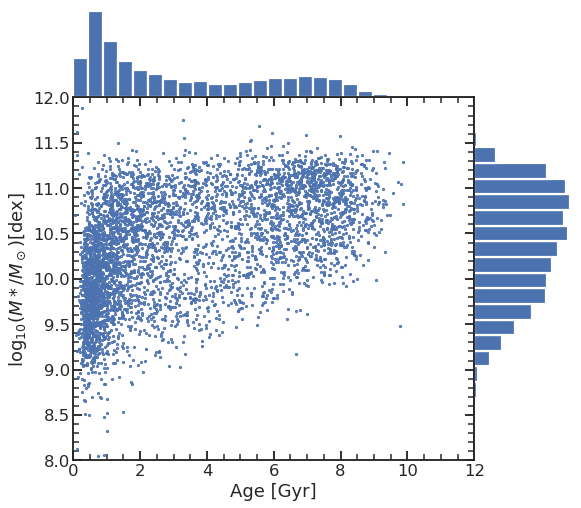

<Figure size 720x720 with 0 Axes>

In [113]:
# data prep
age = age_lw_p3d
mass = mass_p3d

# set up figure
fig = plt.figure(figsize=(8,7))
gs = gridspec.GridSpec(2,2, height_ratios=[0.2,0.8], width_ratios=[0.8,0.2])
gs.update(left=0.12, right=0.99, bottom=0.09, top=0.99, wspace=0., hspace=0.)
ax1 = fig.add_subplot(gs[1,0]) # main
ax2 = fig.add_subplot(gs[0,0]) # top
ax3 = fig.add_subplot(gs[1,1]) # right

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax2.set_yticks([])
ax3.set_xticks([])
ax2.set_xticks([])
ax3.set_yticks([])
ax1.tick_params(top=True,right=True,which='both')

## main plot
plt.figure(figsize=(10,10))
cmap = mpl.cm.jet
cmap.set_bad(cmap(0))
# ax1.hist2d(age,mass,range=[[0,14],[7,14]],bins=50,cmap=cmap,norm=mpl.colors.LogNorm());
ax1.scatter(age,mass,s=1)
ax1.legend(frameon=False)
ax1.set_xlim(0,12)
ax1.set_ylim(8,12)
ax1.set_xlabel(r'Age [Gyr]')
ax1.set_ylabel(r'$\log_{10}(M*/M_\odot)$[dex]')

## top hist
ax2.hist(age,bins=np.linspace(0,13,30))
ax2.set_xlim(0,12)

## right hist
ax3.hist(mass,orientation='horizontal',bins=np.linspace(8,13,30))
ax3.set_ylim(8,12)

# plt.savefig('figures/mass-age-correlation.pdf',bbox_to_inches='tight')

## FIREFLY 
https://www.sdss.org/dr15/data_access/value-added-catalogs/?vac_id=manga-firefly-stellar-populations

In [32]:
from astropy.table import Table
table_firefly_1 = Table.read('manga_firefly-globalprop-v2_4_3.fits',hdu=1)
table_firefly_2 = Table.read('manga_firefly-globalprop-v2_4_3.fits',hdu=2)

print(len(table_firefly_1))

4675


In [86]:
table_firefly_1[:3]

MANGAID,PLATEIFU,PLATE,IFUDSGN,OBJRA,OBJDEC,REDSHIFT,PHOTOMETRIC_MASS,MANGADRP_ver,MANGADAP_ver,FIREFLY_ver
bytes20,bytes20,int16,bytes20,float32,float32,float32,float32,bytes20,bytes20,bytes20
1-138087,8252-12701,8252,12701,144.23926,48.294117,0.0251821,1403080000.0,v2_4_3,v2_2_1,v1_1_0
1-210173,8979-12701,8979,12701,241.34177,42.48831,0.0782043,43249700000.0,v2_4_3,v2_2_1,v1_1_0
1-456925,8933-6102,8933,6102,194.85555,27.96794,0.0256044,6190200000.0,v2_4_3,v2_2_1,v1_1_0


In [87]:
table_firefly_2[:3]

LW_AGE_1Re,LW_AGE_1Re_ERROR,MW_AGE_1Re,MW_AGE_1Re_ERROR,LW_Z_1Re,LW_Z_1Re_ERROR,MW_Z_1Re,MW_Z_1Re_ERROR,LW_AGE_3ARCSEC,LW_AGE_3ARCSEC_ERROR,MW_AGE_3ARCSEC,MW_AGE_3ARCSEC_ERROR,LW_Z_3ARCSEC,LW_Z_3ARCSEC_ERROR,MW_Z_3ARCSEC,MW_Z_3ARCSEC_ERROR
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0.70715755,0.8086257,1.0453601,1.1306632,-0.17899854,0.076403044,-1.3018398,0.43411106,0.48597136,0.21882209,0.71662354,0.29782903,-0.4590855,0.1970481,-1.0549437,0.5612695
0.61643314,0.8664706,0.86921686,1.09146,-0.29493323,0.17177875,-0.7261498,0.059074968,0.6967238,0.08481914,0.77817994,0.107159615,0.15778118,0.05287835,0.1329872,0.07767233
0.82909244,0.95659506,0.9954257,1.0995619,0.006785768,0.07004392,0.11924131,0.23317702,0.9034227,0.06344831,0.98191196,0.047940075,0.09986111,0.061918207,0.13721909,0.05156164


No handles with labels found to put in legend.


(8, 12)

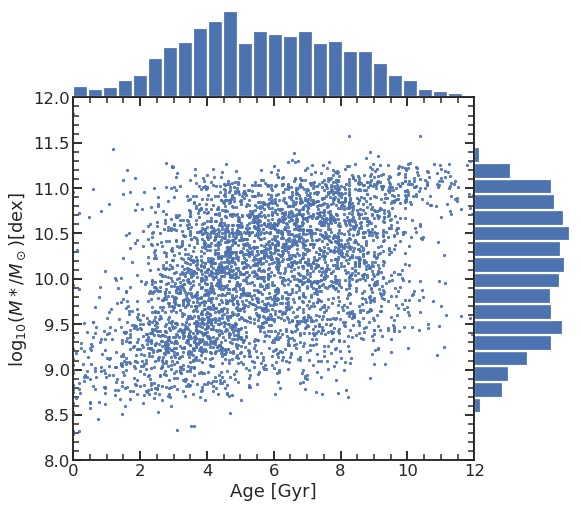

<Figure size 720x720 with 0 Axes>

In [93]:
# data prep
age = (10**table_firefly_2['LW_AGE_1Re'])
mass = np.log10(table_firefly_1['PHOTOMETRIC_MASS'])

# set up figure
fig = plt.figure(figsize=(8,7))
gs = gridspec.GridSpec(2,2, height_ratios=[0.2,0.8], width_ratios=[0.8,0.2])
gs.update(left=0.12, right=0.99, bottom=0.09, top=0.99, wspace=0., hspace=0.)
ax1 = fig.add_subplot(gs[1,0]) # main
ax2 = fig.add_subplot(gs[0,0]) # top
ax3 = fig.add_subplot(gs[1,1]) # right

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax2.set_yticks([])
ax3.set_xticks([])
ax2.set_xticks([])
ax3.set_yticks([])
ax1.tick_params(top=True,right=True,which='both')

## main plot
plt.figure(figsize=(10,10))
cmap = mpl.cm.jet
cmap.set_bad(cmap(0))
# ax1.hist2d(age,mass,range=[[0,14],[7,14]],bins=50,cmap=cmap,norm=mpl.colors.LogNorm());
ax1.scatter(age,mass,s=1)
# ax1.plot(age_th,mass_th,alpha=1,linestyle='--',c='pink')
ax1.legend(frameon=False)
ax1.set_xlim(0,12)
ax1.set_ylim(8,12)
ax1.set_xlabel(r'Age [Gyr]')
ax1.set_ylabel(r'$\log_{10}(M*/M_\odot)$[dex]')

## top hist
ax2.hist(age,bins=np.linspace(0,13,30))
ax2.set_xlim(0,12)

## right hist
ax3.hist(mass,orientation='horizontal',bins=np.linspace(8,13,30))
ax3.set_ylim(8,12)

# plt.savefig('figures/mass-age-correlation.pdf',bbox_to_inches='tight')

## DL morphology

In [33]:
from astropy.table import Table
table_DLmorph = Table.read('manga-morphology-dl-DR15.fits')

print(len(table_DLmorph))

4672


In [79]:
table_DLmorph[:3]

INTID,MANGA-ID,PLATEIFU,OBJID,RA,DEC,Z,DUPL_GR,DUPL_N,DUPL_ID,TTYPE,FLAG_TT,P_S0,FLAG_S0,P_EDGE_ON,P_BAR_GZ2,P_BAR_N10,P_MERG,P_BULGE,P_CIGAR
int32,bytes9,bytes11,int64,float64,float64,float64,int32,int32,int32,float64,int32,float64,int32,float64,float64,float64,float64,float64,float64
1,1-286558,8325-12701,1237661435926544550,210.17634,45.833422,0.04288710891658048,0,0,0,2.9296815395355225,0,0.923401951789856,0,0.0017607815098017454,0.04844723641872406,0.30274492502212524,0.19342143833637238,0.020228391513228416,0.18455101549625397
2,1-274706,8253-12701,1237660634384761005,157.05886,42.96805,0.04496037553087202,0,0,0,3.556624412536621,0,0.9849615097045898,0,0.9991127848625183,0.07391884177923203,0.24563977122306824,0.0029707627836614847,0.03296169638633728,1.0
3,1-201874,8938-12701,1237657118405886241,119.75748,30.976025,0.05276287200043103,0,0,0,3.7636590003967285,0,0.9662042856216431,0,0.8343685865402222,0.05075589567422867,0.3358519375324249,0.2160855531692505,0.04218412563204765,0.8900055289268494


## Galaxy Zoo

In [34]:
# Galaxy Zoo
from marvin.tools.vacs import VACs
v = VACs()
gz = v.galaxyzoo
table_gz = gz.get_table(ext=1)
print(len(table_gz))

[INFO]: No release version set. Setting default to DR15
[WARNING]: path /home/sterling/sas/mangawork/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/sterling/sas/mangawork/manga/spectro/analysis/v2_4_3/2.2.1/dapall-v2_4_3-2.2.1.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[INFO]: VAC galaxyzoo3d has no summary file to load.  Skipping.


29811


In [9]:
table_gz[:3]

nsa_id,IAUNAME,IFUDESIGNSIZE,IFU_DEC,IFU_RA,MANGAID,MANGA_TILEID,OBJECT_DEC,OBJECT_RA,survey,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_count_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_weight_fraction,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_count_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_weight_fraction,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_count_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_weight_fraction,t01_smooth_or_features_count,t01_smooth_or_features_weight,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_count_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_weight_fraction,t02_edgeon_a05_no_count,t02_edgeon_a05_no_count_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_weight_fraction,t02_edgeon_count,t02_edgeon_weight,t03_bar_a06_bar_count,t03_bar_a06_bar_count_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_weight,t03_bar_a06_bar_weight_fraction,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_count_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_weight_fraction,t03_bar_count,t03_bar_weight,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_count_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_weight_fraction,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_count_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_weight_fraction,t04_spiral_count,t04_spiral_weight,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_count_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_weight_fraction,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_count_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_weight_fraction,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_count_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_weight_fraction,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_count_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_weight_fraction,t05_bulge_prominence_count,t05_bulge_prominence_weight,t06_odd_a14_yes_count,t06_odd_a14_yes_count_fraction,t06_odd_a14_yes_debiased,t06_odd_a14_yes_weight,t06_odd_a14_yes_weight_fraction,t06_odd_a15_no_count,t06_odd_a15_no_count_fraction,t06_odd_a15_no_debiased,t06_odd_a15_no_weight,t06_odd_a15_no_weight_fraction,t06_odd_count,t06_odd_weight,t07_rounded_a16_completely_round_count,t07_rounded_a16_completely_round_count_fraction,t07_rounded_a16_completely_round_debiased,t07_rounded_a16_completely_round_weight,t07_rounded_a16_completely_round_weight_fraction,t07_rounded_a17_in_between_count,t07_rounded_a17_in_between_count_fraction,t07_rounded_a17_in_between_debiased,t07_rounded_a17_in_between_weight,t07_rounded_a17_in_between_weight_fraction,t07_rounded_a18_cigar_shaped_count,t07_rounded_a18_cigar_shaped_count_fraction,t07_rounded_a18_cigar_shaped_debiased,t07_rounded_a18_cigar_shaped_weight,t07_rounded_a18_cigar_shaped_weight_fraction,t07_rounded_count,t07_rounded_weight,t09_bulge_shape_a25_rounded_count,t09_bulge_shape_a25_rounded_count_fraction,t09_bulge_shape_a25_rounded_debiased,t09_bulge_shape_a25_rounded_weight,t09_bulge_

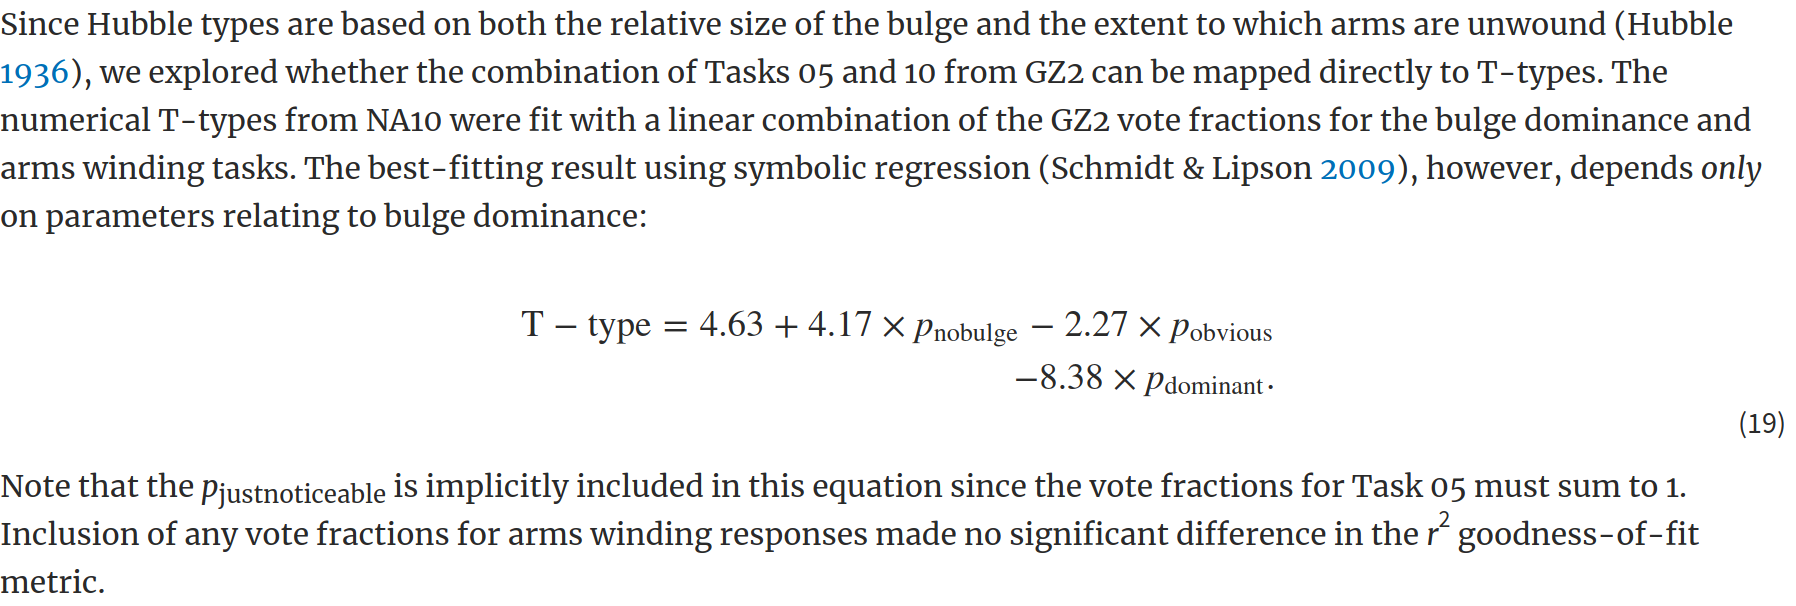

# Cross match all

In [7]:
from tqdm.notebook import tqdm

## P3D

In [37]:
# cross match data -- Pipe3D
columns = ['mangaid','plateifu',
           'p3d_age_lw','p3d_age_mw','p3d_mass',
           'dl_ttype',
           'gz_p_nobulge','gz_p_obvious','gz_p_dominant',
           'gz_ttype']
df_p3d = pd.DataFrame(columns=columns).set_index('mangaid')

for i in tqdm(range(len(table_p3d))):
    p3d_row = table_p3d[i]

    # base info
    plateifu = p3d_row['plateifu']
    loc = drpall['plateifu']== plateifu
    mangaid = drpall[loc]['mangaid'].astype(np.str)[0]
        
    ## Pipe3D info
    p3d_age_lw = 10**p3d_row['age_lw_re_fit']/1e9
    p3d_age_mw = 10**p3d_row['age_mw_re_fit']/1e9
    p3d_mass = p3d_row['log_mass']

    ## Deep Leaning morphology
    loc = np.char.strip(table_DLmorph['MANGA-ID'].astype(str)) == mangaid
    if loc.sum() != 1:
        dl_ttype = np.nan
    else:
        dl_ttype = table_DLmorph[loc]['TTYPE'].data.data[0]
    
    ## Galaxy zoo votes and morphology
    loc = table_gz['MANGAID'] == mangaid
    if loc.sum() != 1:
        gz_p_nobulge, gz_p_obvious, gz_p_dominant, gz_ttype = np.nan,np.nan,np.nan,np.nan
    else:
        gz_p_nobulge = table_gz[loc]['t05_bulge_prominence_a10_no_bulge_debiased'].data.data[0]
        gz_p_obvious = table_gz[loc]['t05_bulge_prominence_a12_obvious_debiased'].data.data[0]
        gz_p_dominant = table_gz[loc]['t05_bulge_prominence_a13_dominant_debiased'].data.data[0]
        gz_ttype = 4.63 + 4.17*gz_p_nobulge - 2.27*gz_p_obvious - 8.38*gz_p_dominant
    
    # save data
    cols = [plateifu,p3d_age_lw,p3d_age_mw,p3d_mass,dl_ttype,gz_p_nobulge,gz_p_obvious,gz_p_dominant,gz_ttype]
    df_p3d.loc[mangaid] = cols
    

100%|██████████| 4656/4656 [03:39<00:00, 21.23it/s]


In [39]:
df_p3d.to_csv('DR15_P3D+DLmorph+GZmorph.csv',index=True)

In [38]:
df_p3d

,plateifu,p3d_age_lw,p3d_age_mw,p3d_mass,dl_ttype,gz_p_nobulge,gz_p_obvious,gz_p_dominant,gz_ttype
mangaid,,,,,,,,,
1-48157,10001-12701,0.424491,4.346691,9.993362,5.133293,0.119048,0.208333,0.000000,4.653512
1-48188,10001-12702,1.082271,7.496357,10.108313,4.653725,0.310345,0.338028,0.000000,5.156814
1-55648,10001-12703,1.403141,8.127124,10.434694,4.587003,0.000000,0.000000,0.000000,4.630000
1-55616,10001-12704,1.442737,6.415253,9.903014,4.569263,0.000000,1.000000,0.000000,2.360000
1-55784,10001-12705,0.693229,5.212680,10.444530,3.641882,0.026316,0.289157,0.055556,3.617796
...,...,...,...,...,...,...,...,...,...
1-373878,9891-6102,0.730323,3.346968,10.116204,4.024856,0.000000,0.000000,0.000000,4.630000
1-373953,9891-6103,6.043057,8.333106,10.761345,-2.247777,0.000000,0.285714,0.266667,1.746762
1-374081,9891-6104,7.266484,9.139897,10.871485,-2.448017,0.000000,0.657143,0.225000,1.252786


## Firefly

In [40]:
# cross match data -- Firefly
columns = ['mangaid','plateifu',
           'ff_age_lw','ff_age_mw','ff_mass',
           'dl_ttype',
           'gz_p_nobulge','gz_p_obvious','gz_p_dominant',
           'gz_ttype']
df_firefly = pd.DataFrame(columns=columns).set_index('mangaid')

for i in tqdm(range(len(table_firefly_2))):

    # base info
    plateifu = table_firefly_1[i]['PLATEIFU']
    loc = drpall['plateifu']== plateifu
    mangaid = drpall[loc]['mangaid'].astype(np.str)[0]
        
    ## Firefly info
    ff_age_lw = 10**table_firefly_2[i]['LW_AGE_1Re']
    ff_age_mw = 10**table_firefly_2[i]['MW_AGE_1Re']
    ff_mass = np.log10(table_firefly_1[i]['PHOTOMETRIC_MASS'])

    ## Deep Leaning morphology
    loc = np.char.strip(table_DLmorph['MANGA-ID'].astype(str)) == mangaid
    if loc.sum() != 1:
        dl_ttype = np.nan
    else:
        dl_ttype = table_DLmorph[loc]['TTYPE'].data.data[0]
    
    ## Galaxy zoo votes and morphology
    loc = table_gz['MANGAID'] == mangaid
    if loc.sum() != 1:
        gz_p_nobulge, gz_p_obvious, gz_p_dominant, gz_ttype = np.nan,np.nan,np.nan,np.nan
    else:
        gz_p_nobulge = table_gz[loc]['t05_bulge_prominence_a10_no_bulge_debiased'].data.data[0]
        gz_p_obvious = table_gz[loc]['t05_bulge_prominence_a12_obvious_debiased'].data.data[0]
        gz_p_dominant = table_gz[loc]['t05_bulge_prominence_a13_dominant_debiased'].data.data[0]
        gz_ttype = 4.63 + 4.17*gz_p_nobulge - 2.27*gz_p_obvious - 8.38*gz_p_dominant
    
    # save data
    cols = [plateifu,ff_age_lw,ff_age_mw,ff_mass,dl_ttype,gz_p_nobulge,gz_p_obvious,gz_p_dominant,gz_ttype]
    df_firefly.loc[mangaid] = cols
    

100%|██████████| 4675/4675 [03:35<00:00, 21.72it/s]


In [41]:
df_firefly.to_csv('DR15_Firefly+DLmorph+GZmorph.csv',index=True)

In [42]:
df_firefly

,plateifu,ff_age_lw,ff_age_mw,ff_mass,dl_ttype,gz_p_nobulge,gz_p_obvious,gz_p_dominant,gz_ttype
mangaid,,,,,,,,,
1-138087,8252-12701,5.095157,11.100949,9.147082,4.315554,NaN,NaN,NaN,NaN
1-210173,8979-12701,4.134597,7.399747,10.635983,3.843814,0.000000,0.473684,0.200000,1.878737
1-456925,8933-6102,6.746716,9.895226,9.791705,-2.224265,0.326087,0.525000,0.000000,4.798033
1-384424,9493-1901,7.119877,8.799097,9.820964,-1.665828,0.000000,0.433333,0.000000,3.646333
1-152527,8144-6101,3.108406,6.886651,9.908625,2.506930,0.068182,0.487179,0.176471,2.329597
...,...,...,...,...,...,...,...,...,...
1-216980,8440-6102,3.569984,6.109491,9.165470,5.199934,0.363636,0.154195,0.038462,5.474033
1-113675,8618-3702,5.904159,7.749269,11.001388,-1.935285,0.000000,0.478261,0.615385,-1.612575
1-604052,8084-3702,4.461112,7.819552,9.662448,1.247447,0.333333,0.440000,0.000000,5.021200


## combine

In [43]:
df_p3d = pd.read_csv('DR15_P3D+DLmorph+GZmorph.csv').set_index('mangaid')
df_firefly = pd.read_csv('DR15_Firefly+DLmorph+GZmorph.csv').set_index('mangaid')

In [44]:
combined = df_p3d.copy()
combined['ff_age_lw'] = np.nan
combined['ff_mass'] = np.nan
combined = combined.combine_first(df_firefly)

In [45]:
# cross-match redshift
combined['z']=np.nan
for idx in combined.index.values:
    z = drpall[drpall['mangaid']==idx]['z'].data[0]
    combined.loc[idx,'z']=z

In [46]:
combined.to_csv('MaNGA_combined_v01.csv',index=True)

# Plots

In [3]:
combined = pd.read_csv('MaNGA_combined_v01.csv').set_index('mangaid')

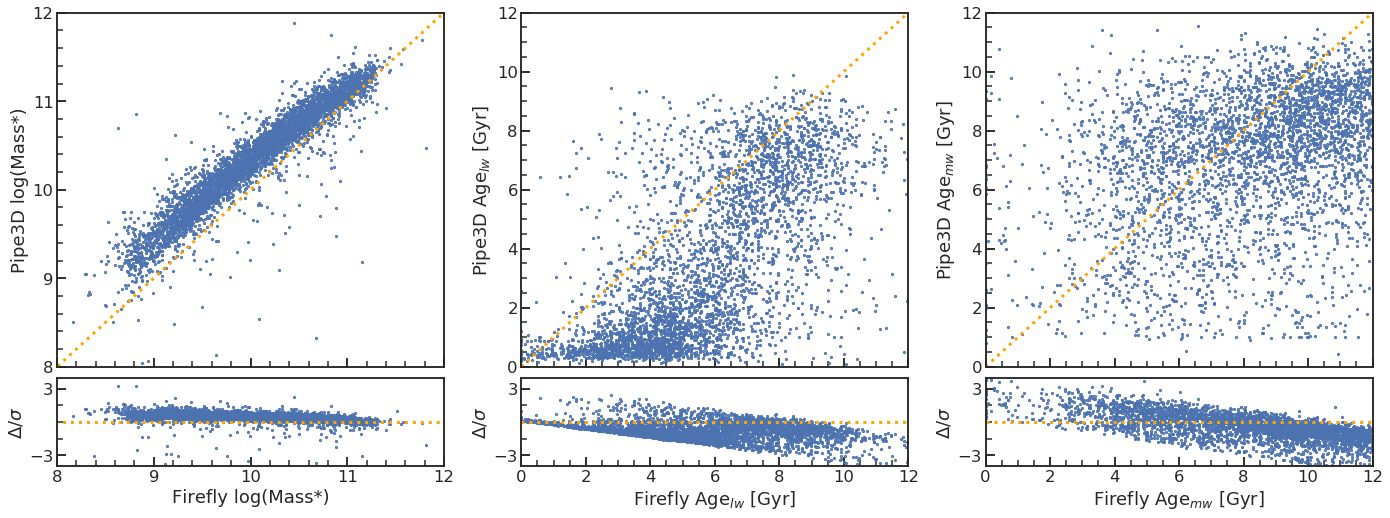

In [5]:
# mass bias & disagreement plot
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(2,3, height_ratios=[0.8,0.2],width_ratios=[0.33,0.33,0.33])
gs.update(left=0.12, right=0.99, bottom=0.09, top=0.99, wspace=0.2, hspace=0.05)

# mass
ax1 = fig.add_subplot(gs[0,0]) # main
ax2 = fig.add_subplot(gs[1,0]) # diff
ax1.scatter(combined['ff_mass'],combined['p3d_mass'],s=1)
ax1.plot([0,15],[0,15],color='orange',linestyle=':',lw=3,alpha=1)
ax1.set_xlim(8,12)
ax1.set_ylim(8,12)
ax1.set_yticks([8,9,10,11,12])
ax1.set_xticklabels([])

m = combined['p3d_mass'].replace([np.inf, -np.inf], np.nan)
mass_std = m[m.notna()].std()
ax2.scatter(combined['ff_mass'],(combined['p3d_mass']-combined['ff_mass'])/mass_std,s=1);
ax2.plot([0,15],[0,0],color='orange',linestyle=':',lw=3,alpha=1)
ax2.set_xlim(8,12)
ax2.set_xticks([8,9,10,11,12])
ax1.set_ylabel(r'Pipe3D log(Mass*)')
ax2.set_xlabel(r'Firefly log(Mass*)')
ax2.set_ylabel(r'$\Delta/\sigma$')
ax2.set_ylim(-4,4)
ax2.set_yticks([-3,3])

# age
ax3 = fig.add_subplot(gs[0,1]) # main
ax4 = fig.add_subplot(gs[1,1]) # diff
ax3.scatter(combined['ff_age_lw'],combined['p3d_age_lw'],s=1)
ax3.plot([0,15],[0,15],color='orange',linestyle=':',lw=3,alpha=1)
ax3.set_xlim(0,12)
ax3.set_ylim(0,12)
ax3.set_xticklabels([])

a = combined['p3d_age_lw'].replace([np.inf, -np.inf], np.nan)
age_std = a[a.notna()].std()
ax4.scatter(combined['ff_age_lw'],(combined['p3d_age_lw']-combined['ff_age_lw'])/age_std,s=1);
ax4.plot([0,15],[0,0],color='orange',linestyle=':',lw=3,alpha=1)
ax4.set_xlim(0,12)
ax3.set_ylabel(r'Pipe3D Age$_{lw}$ [Gyr]')
ax4.set_xlabel(r'Firefly Age$_{lw}$ [Gyr]')
ax4.set_ylabel(r'$\Delta/\sigma$')
ax4.set_ylim(-4,4)
ax4.set_yticks([-3,3])

# age
ax5 = fig.add_subplot(gs[0,2]) # main
ax6 = fig.add_subplot(gs[1,2]) # diff
ax5.scatter(combined['ff_age_mw'],combined['p3d_age_mw'],s=1)
ax5.plot([0,15],[0,15],color='orange',linestyle=':',lw=3,alpha=1)
ax5.set_xlim(0,12)
ax5.set_ylim(0,12)
ax5.set_xticklabels([])

a = combined['p3d_age_mw'].replace([np.inf, -np.inf], np.nan)
age_std = a[a.notna()].std()
ax6.scatter(combined['ff_age_mw'],(combined['p3d_age_mw']-combined['ff_age_mw'])/age_std,s=1);
ax6.plot([0,15],[0,0],color='orange',linestyle=':',lw=3,alpha=1)
ax6.set_xlim(0,12)
ax5.set_ylabel(r'Pipe3D Age$_{mw}$ [Gyr]')
ax6.set_xlabel(r'Firefly Age$_{mw}$ [Gyr]')
ax6.set_ylabel(r'$\Delta/\sigma$')
ax6.set_ylim(-4,4)
ax6.set_yticks([-3,3])

In [83]:
from scipy.stats import gaussian_kde as kde

def plot_by_T(attr,morph_attr,ax,df,xlim=(0,14),showlabel=True,orientation='horizontal',alpha=0.8,lw=3):
    df_final = df
    cm = plt.get_cmap('RdYlBu')
    for i in range(-5,11):
        cut = (df_final[morph_attr]>i-1) & (df_final[morph_attr]<=i)
        cut = cut & df_final[attr].notna() & df_final[morph_attr].notna()
        try:
            kernel = kde(df_final[cut][attr].values)
            age_th = np.linspace(0,14,100)
            dist = kernel(age_th)
            if orientation == 'horizontal':
                ax.set_xlim(xlim)
                ax.plot(age_th,dist/dist.max(),label=f'{i-1:2} < T '+r'$\leq$'+f'{i:2}',c=cm((i+5)/16),alpha=alpha,lw=lw)
            elif orientation == 'vertical':
                ax.set_ylim(xlim)
                ax.plot(dist/dist.max(),age_th,label=f'{i-1:2} < T '+r'$\leq$'+f'{i:2}',c=cm((i+5)/16),alpha=alpha,lw=lw)
            else:
                print('orientation not specified correctly')
                return 1
        except:
            continue
    if showlabel:
        ax.set_xlabel(attr)


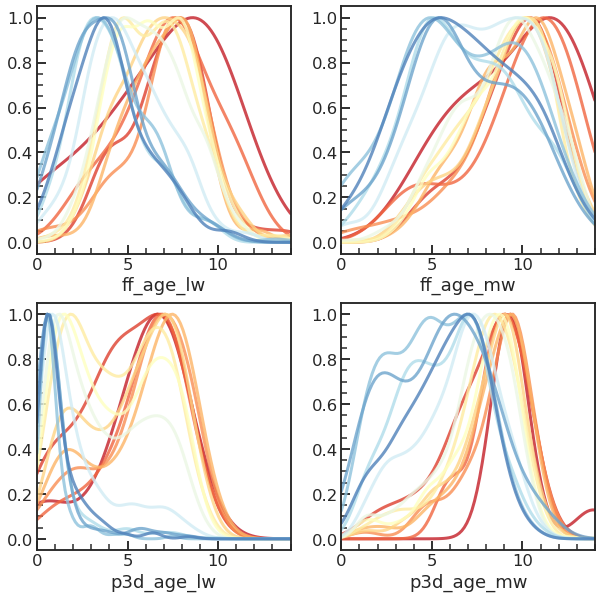

In [84]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
plot_by_T('ff_age_lw','gz_ttype',ax1,df=combined)
plot_by_T('ff_age_mw','gz_ttype',ax2,df=combined)
plot_by_T('p3d_age_lw','gz_ttype',ax3,df=combined)
plot_by_T('p3d_age_mw','gz_ttype',ax4,df=combined)

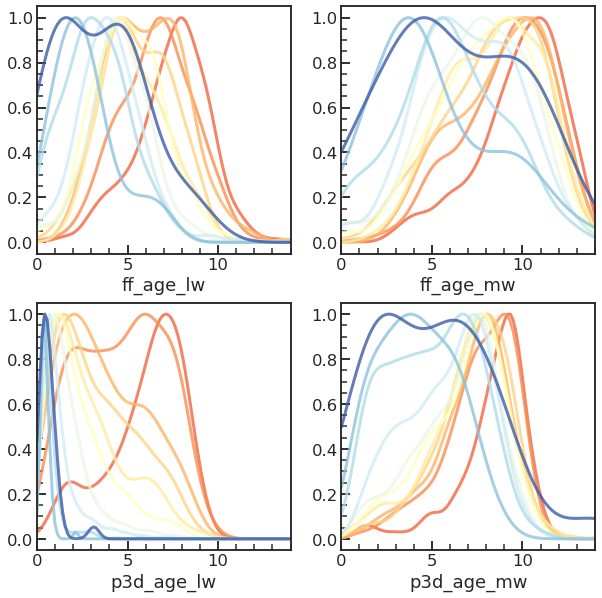

In [85]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
plot_by_T('ff_age_lw','dl_ttype',ax1,df=combined)
plot_by_T('ff_age_mw','dl_ttype',ax2,df=combined)
plot_by_T('p3d_age_lw','dl_ttype',ax3,df=combined)
plot_by_T('p3d_age_mw','dl_ttype',ax4,df=combined)

In [133]:
# plot GZ ttype

def plot_MassAge(age_attr,mass_attr,ttype_attr,xlim=(0,13),ylim=(8,12),
                xlabel=r'Age [Gyr]', ylabel=r'$\log_{10}(M*/M_\odot)$[dex]'):
    cut = combined[ttype_attr].notna()# & (df_p3d['dl_ttype']<0)
    age = combined[cut][age_attr]
    mass = combined[cut][mass_attr]
    ttype = combined[cut][ttype_attr]
    cmap = 'RdYlBu' 

    # set up figure
    fig = plt.figure(figsize=(8.5,7))
    gs = gridspec.GridSpec(2,4, height_ratios=[0.2,0.8], width_ratios=[0.75,0.1875,0.04,0.0225])
    gs.update(left=0.12, right=0.99, bottom=0.09, top=0.99, wspace=0., hspace=0.)
    ax1 = fig.add_subplot(gs[1,0]) # main
    ax2 = fig.add_subplot(gs[0,0]) # top
    ax3 = fig.add_subplot(gs[1,1]) # right
    cax = fig.add_subplot(gs[0:,3])

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax2.set_yticks([])
    ax3.set_xticks([])
    ax2.set_xticks([])
    ax3.set_yticks([])
    ax1.tick_params(top=True,right=True,which='both')

    ## main plot
    plt.figure(figsize=(10,10))
    ax1.scatter(age,mass,c=ttype,cmap=cmap,s=1,alpha=1)
    ax1.legend(frameon=False)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ## top hist
    plot_by_T(age_attr,ttype_attr,ax2,df=combined,showlabel=False,alpha=0.8,lw=2)
    ax2.set_xlim(xlim)

    ## right hist
    plot_by_T(mass_attr,ttype_attr,ax3,df=combined,orientation='vertical',showlabel=False,alpha=0.8,lw=2)
    ax3.set_ylim(ylim)

    ## colorbar
    N=16
    cb_cmap = plt.get_cmap(cmap,N)
    norm = mpl.colors.Normalize(vmin=-5,vmax=10)
    sm = plt.cm.ScalarMappable(cmap=cb_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=np.linspace(10,-5,N), cax=cax,
                 boundaries=np.arange(-5.1,10.1,.1))
#     cax.set_title('Galaxy Zoo T-type')
    cbar.set_label('GZ T-type', rotation=270,labelpad=20)
    cax.invert_yaxis()
# plt.savefig('figures/mass-age-correlation.pdf',bbox_to_inches='tight')

No handles with labels found to put in legend.
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


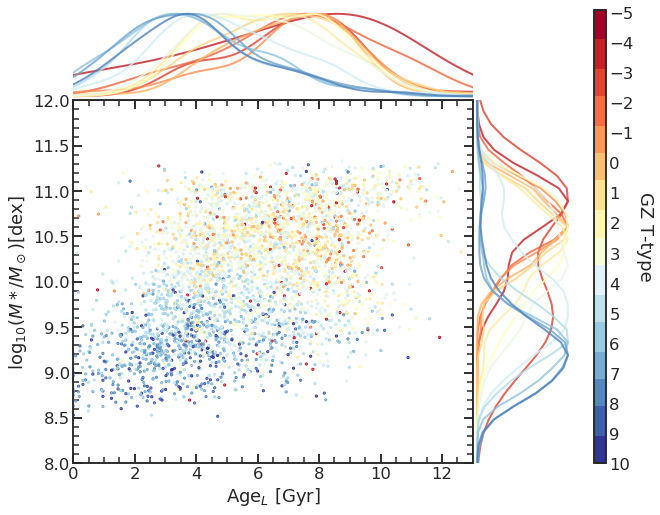

<Figure size 720x720 with 0 Axes>

In [129]:
plot_MassAge('ff_age_lw','ff_mass','gz_ttype',xlabel=r'Age$_L$ [Gyr]')

No handles with labels found to put in legend.
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


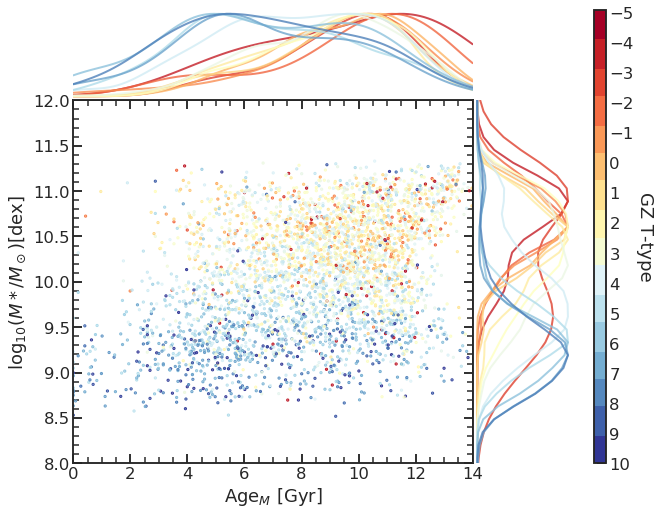

<Figure size 720x720 with 0 Axes>

In [130]:
plot_MassAge('ff_age_mw','ff_mass','gz_ttype',xlabel=r'Age$_M$ [Gyr]',xlim=(0,14))

No handles with labels found to put in legend.
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


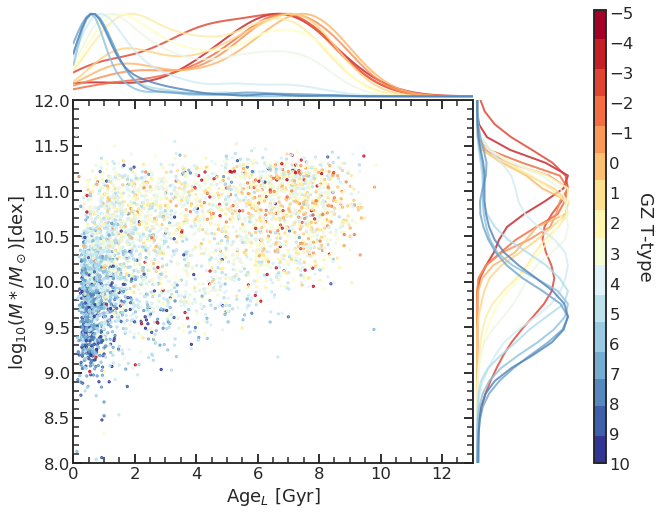

<Figure size 720x720 with 0 Axes>

In [134]:
plot_MassAge('p3d_age_lw','p3d_mass','gz_ttype',xlabel=r'Age$_L$ [Gyr]')

No handles with labels found to put in legend.
[WARNING]: invalid value encountered in log10 (RuntimeWarning)


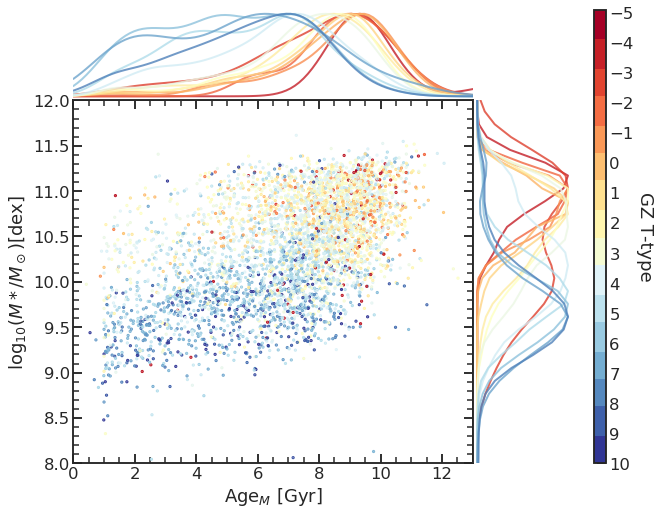

<Figure size 720x720 with 0 Axes>

In [136]:
plot_MassAge('p3d_age_mw','p3d_mass','gz_ttype',xlabel=r'Age$_M$ [Gyr]')

In [132]:
combined

,dl_ttype,ff_age_lw,ff_age_mw,ff_mass,gz_p_dominant,gz_p_nobulge,gz_p_obvious,gz_ttype,p3d_age_lw,p3d_age_mw,p3d_mass,plateifu,z
mangaid,,,,,,,,,,,,,
1-109056,-0.295236,5.627043,11.522521,10.087256,0.000000,0.000000,0.533105,3.419852,2.627942,9.136265,10.594612,8077-6103,0.047302
1-109073,5.497689,4.887990,9.856050,9.750732,0.000000,0.580000,0.000000,7.048600,1.022974,5.749931,10.148505,8078-12704,0.043588
1-109081,3.816341,4.617247,7.556923,10.593996,0.133041,0.000000,0.535174,2.300274,2.614249,7.783762,10.866787,8077-12705,0.043859
1-109112,-2.166219,7.283097,8.775743,9.980397,0.250000,0.000000,0.741935,0.850806,4.961248,7.108517,10.267340,8078-1901,0.024970
1-109152,-2.046823,NaN,NaN,10.895902,0.333333,0.096774,0.508564,1.085774,6.900712,9.570910,11.038169,8154-12702,0.028174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12-84677,0.899289,7.446391,11.551152,10.887141,NaN,NaN,NaN,NaN,4.591695,7.065999,11.019137,7443-6104,0.075096
12-84679,-2.096029,7.029472,11.315525,10.980842,NaN,NaN,NaN,NaN,5.931998,7.832784,11.105212,7443-9102,0.091575
12-84726,4.579235,NaN,NaN,8.688707,NaN,NaN,NaN,NaN,0.642134,1.874483,9.174378,7443-6101,0.030912
